In [1]:
import sys
sys.path.insert(0, "../")
from tmds import *
import os
%matplotlib inline

2.7.12 (default, Nov 12 2018, 14:36:49) 
[GCC 5.4.0 20160609]


In [2]:
from sklearn.preprocessing import StandardScaler as SS
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.utils import resample
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder

In [3]:
s = ["CHA", "SFA-Ctk", "SFA-Pw", "SHA-Ctk", "SHA-Pw", "SRHA"]
cities = ["a", "b", "c", "d", "e"]

In [4]:
df = pd.read_csv("data.csv", "\t")
df["abundance"] = np.log(df["abundance"])
df["H/C"] = df["H"] / df["C"]
df["O/C"] = df["O"] / df["C"]
df["DBE"] = df["C"] - df["H"]/2 + df["N"]/2 + 1
df.sample(10)

,exp,town,abundance,mw,error,C,H,O,N,S,y,H/C,O/C,DBE
69011,SFA-Pw,c,-3.668681,528.272416,0.184445,30,40,8,0,0,5,1.333333,0.266667,11.0
51724,SFA-Pw,a,-5.175761,636.111496,-0.038438,31,24,15,0,0,4,0.774194,0.483871,20.0
23160,SFA-Ctk,a,-5.535703,674.086766,0.005464,28,22,18,2,0,2,0.785714,0.642857,19.0
91649,SHA-Ctk,e,-3.876821,376.110036,0.243346,26,16,3,0,0,2,0.615385,0.115385,19.0
27383,SFA-Ctk,a,-4.856322,862.180316,-0.083612,38,38,23,0,0,1,1.000000,0.605263,20.0
57139,SFA-Pw,a,-6.504698,407.031106,0.007336,17,13,9,1,1,1,0.764706,0.529412,12.0
5980,CHA,b,-5.532039,434.209336,0.027008,27,30,5,0,0,4,1.111111,0.185185,13.0
3822,CHA,a,-7.108024,440.016826,-0.013679,24,8,9,0,0,4,0.333333,0.375000,21.0
101398,SHA-Pw,c,-4.110387,482.027366,-0.063758,26,10,10,0,0,5,0.384615,0.384615,22.0
130688,SRHA,d,-4.231353,523.054206,0.497360,28,13,10,1,0,1,0.464286,0.357143,23.0


In [5]:
db = pd.get_dummies(df[["town", "abundance", "H/C", "O/C", "N", "S", "DBE", "mw", "error", "y"]])
db["exp"] = df["exp"]
db["y"] = (db["y"] >= 5) * 1
db["town"] = df["town"]
db.sample(5)

,abundance,H/C,O/C,N,S,DBE,mw,error,y,town_a,town_b,town_c,town_d,town_e,exp,town
36937,-3.353859,0.470588,0.411765,0,0,14.0,324.026986,-0.051659,1,0,0,1,0,0,SFA-Ctk,c
88584,-4.574828,1.125000,0.625000,0,0,8.0,370.089846,-0.408087,0,0,0,0,1,0,SHA-Ctk,d
69735,-2.176197,0.947368,0.473684,0,0,11.0,390.095136,0.137431,1,0,0,1,0,0,SFA-Pw,c
118554,-5.072247,0.692308,0.576923,0,1,18.0,602.036686,0.073037,0,1,0,0,0,0,SRHA,a
41133,-3.548577,1.615385,0.346154,0,0,6.0,498.282866,-0.034673,0,0,0,0,1,0,SFA-Ctk,d


In [6]:
len(db)

138385

In [7]:
db.exp.unique()
#['CHA', 'SFA-Ctk', 'SFA-Pw', 'SHA-Ctk', 'SHA-Pw', 'SRHA']
#I will not use CHA, SHA-Ctk
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
model = Pipeline([("ss", SS()), ("svm", LR())])

ans = []

for i in range(4):
    train = filter(lambda x: x != exps[i], exps)
    train = pd.concat(list(map(lambda x: db[db["exp"] == x], train)))
    
    one = train[train["y"] == 1]
    zer = train[train["y"] == 0]
    print(len(one))
    print(len(zer))
    tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
    
    
    test = db[db["exp"] == exps[i]]
    
    print "fitting..."
    model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    print "scoring..."
    print exps[i]
    
    ans.append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
    print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
    print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
    print "test:            ", f1_score(ans[-1], test["y"])
    
    
    

22520
52792
fitting...
scoring...
SFA-Ctk
balanced train:   0.788030141805
unbalanced train: 0.679601468275
test:             0.529456939111
19010
54106
fitting...
scoring...
SFA-Pw
balanced train:   0.767932489451
unbalanced train: 0.6229494511
test:             0.687436406803
21580
59606
fitting...
scoring...
SHA-Pw
balanced train:   0.812016509168
unbalanced train: 0.685751290402
test:             0.442096774194
22105
59045
fitting...
scoring...
SRHA
balanced train:   0.76497249725
unbalanced train: 0.625627552948
test:             0.701123052771


In [8]:
db["y_pred"] = 0
for i in range(4):
    db.loc[db["exp"] == exps[i], "y_pred"] = ans[i]

In [9]:
data_1 = []
for i in range(4):
    data_1.append([])
    for j in range(5):
        data_1[-1].append(get_set_of_tuples_from_np(df[(df["exp"] == exps[i]) & (db["y"] == 1) & (df["town"] == cities[j])][elems].values))

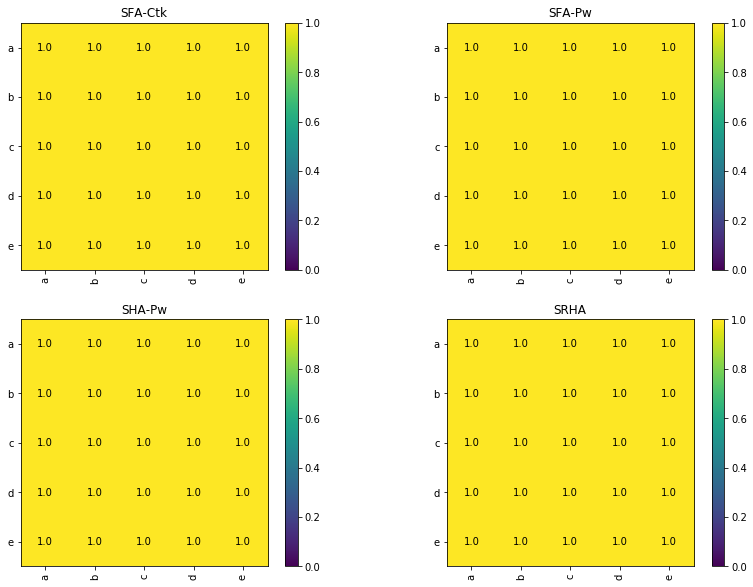

In [10]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_1[e][i], data_1[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [11]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

In [12]:
data = []
for i in range(4):
    data.append([])
    for j in range(5):
        data[-1].append(get_set_of_tuples_from_np(df[(df["exp"] == exps[i]) & 
                                                             (df["town"] == cities[j]) & 
                                                             (df["y"] > 0)][elems].values))

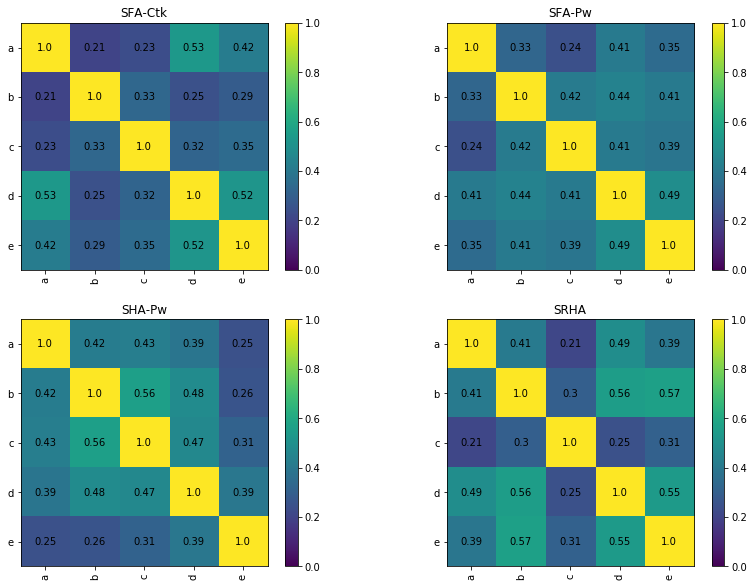

In [13]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data[e][i], data[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

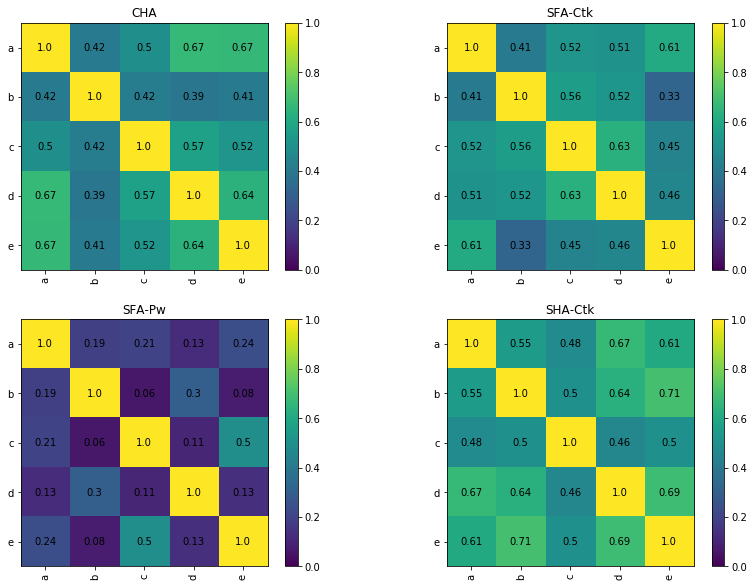

In [14]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(s[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [15]:
models = []
ans = []
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
for t in range(5):
    model = Pipeline([("ss", SS()), ("svm", LR())])
    ans.append([])
    for i in range(4):
        train = filter(lambda x: x != exps[i], exps)
        k = map(lambda x: db[(db["exp"] == x) & (db["town"] == cities[t])], train)
        train = pd.concat(k)

        test = db[(db["exp"] == exps[i]) & (db["town"] == cities[t])]
    
        one = train[train["y"] == 1]
        zer = train[train["y"] == 0]
        print(len(one))
        print(len(zer))
        tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
        model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    
    
        ans[-1].append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
        print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
        print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
        print "test:            ", f1_score(ans[-1][-1], test["y"])

4504
16042
balanced train:   0.847002813244
unbalanced train: 0.685944619699
test:             0.474312149988
3802
15043
balanced train:   0.822989677584
unbalanced train: 0.637260706532
test:             0.667151515152
4316
22156
balanced train:   0.858612975391
unbalanced train: 0.644554538584
test:             0.572192513369
4421
18906
balanced train:   0.835064935065
unbalanced train: 0.626552984166
test:             0.635514018692
4504
8187
balanced train:   0.773262269598
unbalanced train: 0.698075380914
test:             0.678370786517
3802
6781
balanced train:   0.758812615955
unbalanced train: 0.68789043729
test:             0.687367976341
4316
8968
balanced train:   0.835740072202
unbalanced train: 0.755455843361
test:             0.0649717514124
4421
6877
balanced train:   0.741463414634
unbalanced train: 0.688490837966
test:             0.670054446461
4504
3821
balanced train:   0.72610619469
unbalanced train: 0.743122381977
test:             0.594362745098
3802
3836
balanc

In [16]:
db["y_pred"] = 0
for i in range(4):
    for t in range(5):
        db.loc[(db["exp"] == exps[i]) & (db["town"] == cities[t]), "y_pred"] = ans[t][i]

In [17]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

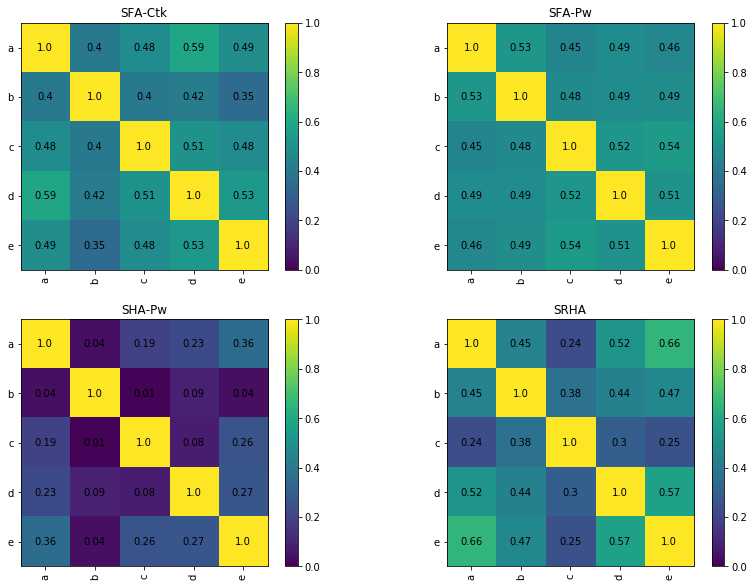

In [18]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [24]:
models = []
ans = []
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
for t in range(5):
    model = Pipeline([("ss", SS()), ("svm", SVC())])
    ans.append([])
    for i in range(4):
        train = filter(lambda x: x != exps[i], exps)
        k = map(lambda x: db[(db["exp"] == x) & (db["town"] == cities[t])], train)
        train = pd.concat(k)

        test = db[(db["exp"] == exps[i]) & (db["town"] == cities[t])]
    
        one = train[train["y"] == 1]
        zer = train[train["y"] == 0]
        print(len(one))
        print(len(zer))
        tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
        model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    
    
        ans[-1].append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
        print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
        print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
        print "test:            ", f1_score(ans[-1][-1], test["y"])

10186
10360
balanced train:   0.887898459452
unbalanced train: 0.885367856625
test:             0.821057288211
10102
8743
balanced train:   0.873649738501
unbalanced train: 0.881491344874
test:             0.785290915689
12276
14196
balanced train:   0.886101314524
unbalanced train: 0.874051233397
test:             0.77416481069
11203
12124
balanced train:   0.875965627984
unbalanced train: 0.868801652893
test:             0.821690140845
9784
2907
balanced train:   0.886086591005
unbalanced train: 0.913641781341
test:             0.884700122399
8229
2354
balanced train:   0.890403251016
unbalanced train: 0.916532595405
test:             0.928126621692
9573
3711
balanced train:   0.893252183117
unbalanced train: 0.919331118253
test:             0.4540302267
8465
2833
balanced train:   0.909865656625
unbalanced train: 0.936867763559
test:             0.732213951878
7111
1214
balanced train:   0.911610540676
unbalanced train: 0.937873975031
test:             0.951282561145
6682
956
balanc

In [25]:
db["y_pred"] = 0
for i in range(4):
    for t in range(5):
        db.loc[(db["exp"] == exps[i]) & (db["town"] == cities[t]), "y_pred"] = ans[t][i]

In [26]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

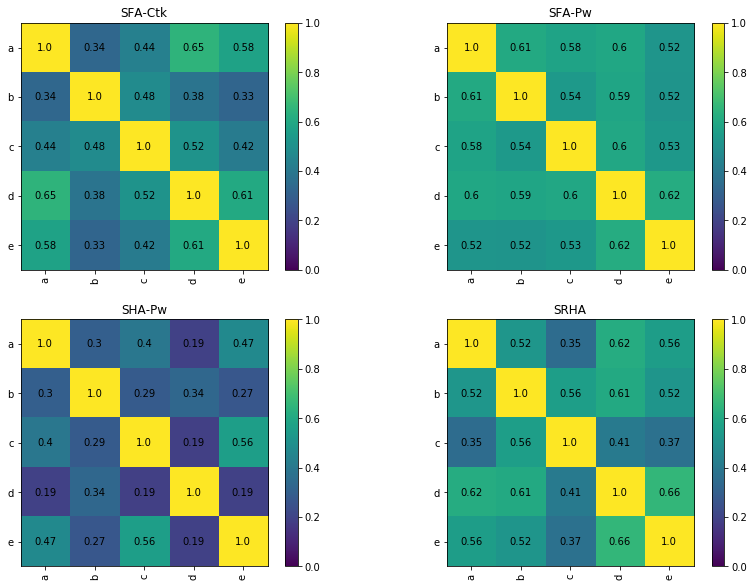

In [27]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})